# Laboratorium 03 - Interpolacja

Dawid Żak, Szymon Hołysz

Populacja Stanów Zjednoczonych na przestrzeni lat przedstawiała
się następująco:

In [35]:
import pandas as pd
import numpy as np
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [36]:
data = """
Rok,Populacja
1900,76_212_168
1910,92_228_496
1920,106_021_537
1930,123_202_624
1940,132_164_569
1950,151_325_798
1960,179_323_175
1970,203_302_031
1980,226_542_199
"""

df = pd.read_csv(StringIO(data))

display(df)

,Rok,Populacja
0,1900,76_212_168
1,1910,92_228_496
2,1920,106_021_537
3,1930,123_202_624
4,1940,132_164_569
5,1950,151_325_798
6,1960,179_323_175
7,1970,203_302_031
8,1980,226_542_199


Istnieje dokładnie jeden wielomian ósmego stopnia, który interpoluje po-
wyższe dziewięć punktów, natomiast sam wielomian może być reprezentowa-
ny na różne sposoby. Rozważamy następujące zbiory funkcji bazowych $\phi_j(t), j = 1, ..., 9$

1.  $$\phi_j(t) = t^{j-1}$$
2.  $$\phi_j(t) = (t - 1900)^{j-1}$$
3.  $$\phi_j(t) = (t - 1940)^{j-1}$$
4.  $$\phi_j(t) = \left( \frac{t - 1940}{40} \right)^{j-1}$$

### A. Dla każdego z czterech zbiorów funkcji bazowych utwórz macierz Vandermonde’a.

In [37]:
def phi1(t, j):
    return (t) ** (j - 1)


def phi2(t, j):
    return (t - 1900) ** (j - 1)


def phi3(t, j):
    return (t - 1940) ** (j - 1)


def phi4(t, j):
    return ((t - 1940) / 40) ** (j - 1)


phi_functions = [phi1, phi2, phi3, phi4]
vandermonde_matrixes = [
    np.array([[phi(t, j) for j in range(1, 10)] for t in df["Rok"]], dtype=np.float64)
    for phi in phi_functions
]


### B. Oblicz współczynnik uwarunkowania każdej z powyższch macierzy.

Najlepiej uwarunkowana okazała się funkcja bazowa nr. 4, która daje najmniejsze współczynniki uwarunkowania macierzy Vandermonde'a.

In [38]:
cond_list = [np.linalg.cond(matrix) for matrix in vandermonde_matrixes]
for i, cond in enumerate(cond_list):
    print(f"phi{i + 1}: {np.format_float_scientific(cond, precision=4)}")

min_cond_index = np.argmin(cond_list)
print(
    f"The index of the function with the lowest condition number is: {min_cond_index + 1}"
)

phi1: 4.3778e+37
phi2: 6.2111e+15
phi3: 9.3155e+12
phi4: 1.6054e+03
The index of the function with the lowest condition number is: 4


Poniżej znajduje się jej macierz Vandermonde'a:

In [39]:
V_best = vandermonde_matrixes[min_cond_index]
display(pd.DataFrame(V_best))

,0,1,2,3,4,5,6,7,8
0,1.0,-1.00,1.0000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000
1,1.0,-0.75,0.5625,-0.421875,0.316406,-0.237305,0.177979,-0.133484,0.100113
2,1.0,-0.50,0.2500,-0.125000,0.062500,-0.031250,0.015625,-0.007812,0.003906
3,1.0,-0.25,0.0625,-0.015625,0.003906,-0.000977,0.000244,-0.000061,0.000015
4,1.0,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.0,0.25,0.0625,0.015625,0.003906,0.000977,0.000244,0.000061,0.000015
6,1.0,0.50,0.2500,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906
7,1.0,0.75,0.5625,0.421875,0.316406,0.237305,0.177979,0.133484,0.100113
8,1.0,1.00,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Następnie wyliczamy współczynniki uwarunkowania macierzy dla tej, która jest najlepiej uwarunkowana:

In [40]:
y = np.float64(df["Populacja"].values)
coefficients = np.linalg.solve(V_best, y)
print(f"coefficients: {coefficients}")

coefficients: [ 1.32164569e+08  4.61307656e+07  1.02716315e+08  1.82527130e+08
 -3.74614715e+08 -3.42668456e+08  6.06291250e+08  1.89175576e+08
 -3.15180235e+08]


### C. Używając najlepiej uwarunkowanej bazy wielomianów, znajdź współczynniki wielomianu interpolacyjnego dla danych z zadania. Narysuj wielomian interpolacyjny. W tym celu użyj schematu Hornera i oblicz na przedziale [1900,1990] wartości wielomianu w odstępach jednorocznych. Na wykresie umieść także węzły interpolacji.

Poniżej znajduje się wykres przedstawiającu wartości przewidziane przez wielomian oraz wartości rzeczywiste:

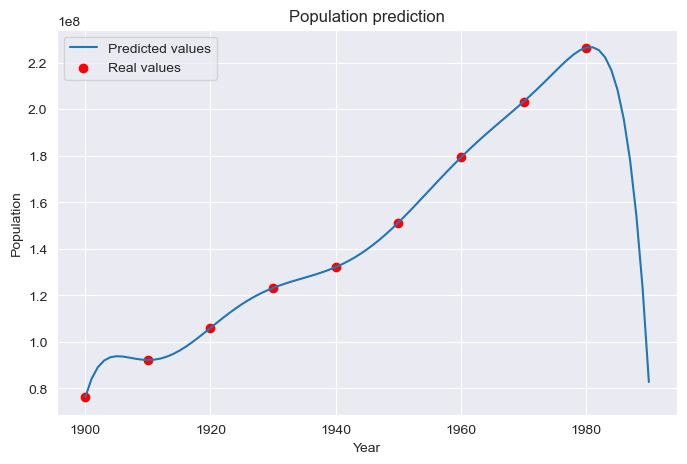

In [41]:
def horner(x, coefficients):
    result = 0
    for coefficient in reversed(coefficients):
        result = result * x + coefficient
    return result


years = np.arange(1900, 1991)
x_list = [(t - 1940) / 40 for t in years]
predicted_values = [horner(x, coefficients) for x in x_list]
plt.figure(figsize=(8, 5))
plt.plot(years, predicted_values, label="Predicted values")
plt.scatter(
    df["Rok"],
    df["Populacja"].str.replace("_", "").astype(float),
    label="Real values",
    color="red",
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.title("Population prediction")
plt.show()

### D. Dokonaj ekstrapolacji wielomianu do roku 1990. Porównaj otrzymaną wartość z prawdziwą wartością dla roku 1990, wynoszącą 248 709 873. Ile wynosi błąd względny ekstrapolacji dla roku 1990?

In [42]:
year_1990_value = 248_709_873
x_1990 = (1990 - 1940) / 40
predicted_1990_value = horner(x_1990, coefficients)
print(
    f"Przewidziana populacja w roku 1990: {np.format_float_scientific(predicted_1990_value, precision=4)}"
)
print(
    f"Realna wartość populacji w roku 1990: {np.format_float_scientific(year_1990_value, precision=4)}"
)
print(
    f"Błąd względny: {round(abs(predicted_1990_value - year_1990_value) / year_1990_value, 2)}"
)

Przewidziana populacja w roku 1990: 8.2749e+07
Realna wartość populacji w roku 1990: 2.4871e+08
Błąd względny: 0.67


Jak możemy zauważyć, wartości przewidziane przez wielomian dla roku 1990 są bardzo różne od wartości rzeczywistych.

### E. Wyznacz wielomian interpolacyjny Lagrange’a na podstawie 9 węzłów interpolacji podanych w zadaniu. Oblicz wartości wielomianu w odstępach jednorocznych.

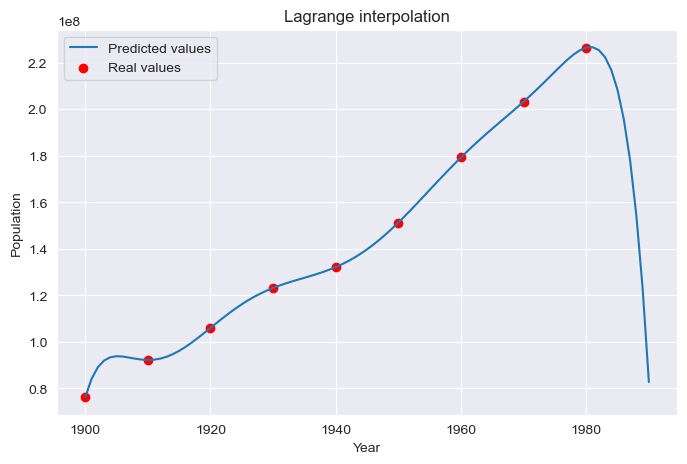

In [43]:
def lagrange_interpolation(x, x_values, y_values):
    result = 0
    for i in range(len(y_values)):
        term = y_values[i]
        for j in range(len(y_values)):
            if i != j:
                term = term * (x - x_values[j]) / (x_values[i] - x_values[j])
        result += term
    return result


x_values = df["Rok"].values
y_values = df["Populacja"].str.replace("_", "").astype(float).values
predicted_values = [lagrange_interpolation(x, x_values, y_values) for x in years]
plt.figure(figsize=(8, 5))
plt.plot(years, predicted_values, label="Predicted values")
plt.scatter(
    df["Rok"],
    df["Populacja"].str.replace("_", "").astype(float),
    label="Real values",
    color="red",
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.title("Lagrange interpolation")
plt.show()

### F. Wyznacz wielomian interpolacyjny Newtona na podstawie tych samych węzłów interpolacji i oblicz wartości wielomianu w odstępach jednorocznych. 

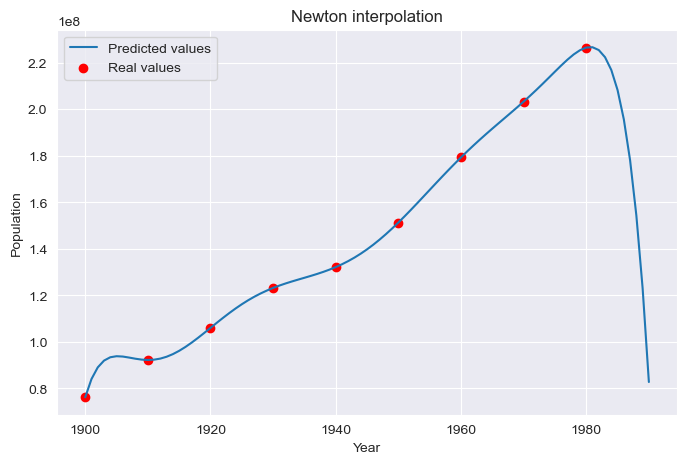

In [44]:
def newton_coefficient(x, y):
    m = len(x)

    x = np.copy(x)
    a = np.copy(y)
    for k in range(1, m):
        a[k:m] = (a[k:m] - a[k - 1]) / (x[k:m] - x[k - 1])

    return a


def newton_interpolation(x, x_values, y_values):
    a = newton_coefficient(x_values, y_values)
    n = len(x_values) - 1
    p = a[n]

    for k in range(1, n + 1):
        p = a[n - k] + (x - x_values[n - k]) * p

    return p


predicted_values = [newton_interpolation(x, x_values, y_values) for x in years]
plt.figure(figsize=(8, 5))
plt.plot(years, predicted_values, label="Predicted values")
plt.scatter(
    df["Rok"],
    df["Populacja"].str.replace("_", "").astype(float),
    label="Real values",
    color="red",
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.title("Newton interpolation")
plt.show()

### G. Zaokrąglij dane podane w tabeli do jednego miliona. Na podstawie takich danych wyznacz wielomian interpolacyjny ósmego stopnia, używając najlepiej uwarunkowanej bazy z podpunktu (c). Porównaj wyznaczone współczynniki z współczynnikami obliczonymi w podpunkcie (c). Wyjaśnij otrzymany wynik. Ile wynosi błąd względny ekstrapolacji dla roku 1990 obliczony przy pomocy tak wyznaczonego wielomianu interpolacyjnego?

Poniżej znajduje się tablica z zaokrąglonymi wartościami do 1 000 000:

In [45]:
df["Populacja"] = (
    df["Populacja"].str.replace("_", "").astype(float).round(-6).astype(int)
)
vandermonde_matrixes = [
    np.array([[phi(t, j) for j in range(1, 10)] for t in df["Rok"]], dtype=np.float64)
    for phi in phi_functions
]

display(df)

,Rok,Populacja
0,1900,76000000
1,1910,92000000
2,1920,106000000
3,1930,123000000
4,1940,132000000
5,1950,151000000
6,1960,179000000
7,1970,203000000
8,1980,227000000


Wartości uwarunkowania dla różnych zbiorów funkcji bazowych:

In [46]:
cond_list = [np.linalg.cond(matrix) for matrix in vandermonde_matrixes]
for i, cond in enumerate(cond_list):
    print(f"phi{i + 1}: {np.format_float_scientific(cond, precision=4)}")

min_cond_index = np.argmin(cond_list)
print(
    f"The index of the function with the lowest condition number is: {min_cond_index + 1}"
)

phi1: 4.3778e+37
phi2: 6.2111e+15
phi3: 9.3155e+12
phi4: 1.6054e+03
The index of the function with the lowest condition number is: 4


Przyjmują one prawie identyczne wartości, co te wyliczone z nie zaokrąglonymi wartościami.

In [47]:
V_best = vandermonde_matrixes[min_cond_index]
display(pd.DataFrame(V_best))

,0,1,2,3,4,5,6,7,8
0,1.0,-1.00,1.0000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000
1,1.0,-0.75,0.5625,-0.421875,0.316406,-0.237305,0.177979,-0.133484,0.100113
2,1.0,-0.50,0.2500,-0.125000,0.062500,-0.031250,0.015625,-0.007812,0.003906
3,1.0,-0.25,0.0625,-0.015625,0.003906,-0.000977,0.000244,-0.000061,0.000015
4,1.0,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.0,0.25,0.0625,0.015625,0.003906,0.000977,0.000244,0.000061,0.000015
6,1.0,0.50,0.2500,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906
7,1.0,0.75,0.5625,0.421875,0.316406,0.237305,0.177979,0.133484,0.100113
8,1.0,1.00,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Wartości współczynników dla najlepiej uwarunkowanej macierzy:

In [48]:
y = np.float64(df["Populacja"].values)
rounded_coefficients = np.linalg.solve(V_best, y)
print(f"coefficients: {rounded_coefficients}")

coefficients: [ 1.32000000e+08  4.59571429e+07  1.00141270e+08  1.81111111e+08
 -3.56755556e+08 -3.38488889e+08  5.70311111e+08  1.86920635e+08
 -2.94196825e+08]


Poniżej znajduje się wykres przedstawiającu wartości przewidziane przez wielomian oraz wartości rzeczywiste:

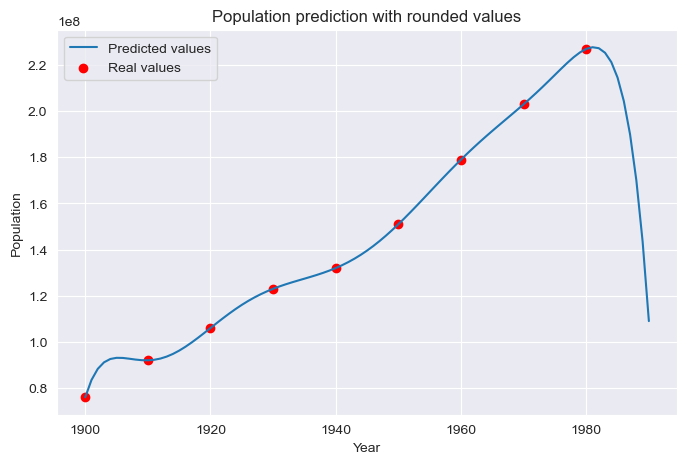

In [49]:
years = np.arange(1900, 1991)
x_list = [(t - 1940) / 40 for t in years]
rounded_predicted_values = [horner(x, rounded_coefficients) for x in x_list]
plt.figure(figsize=(8, 5))
plt.plot(years, rounded_predicted_values, label="Predicted values")
plt.scatter(
    df["Rok"],
    df["Populacja"],
    label="Real values",
    color="red",
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.title("Population prediction with rounded values")
plt.show()

Współczynniki zaokrąglone i nie zaokrąglone, przymują różne,lecz nie drastycznie wartości.

In [50]:
coefficients_df = pd.DataFrame({
    'Original Coefficients': coefficients,
    'Rounded Coefficients': rounded_coefficients
})

display(coefficients_df)

,Original Coefficients,Rounded Coefficients
0,1.321646e+08,1.320000e+08
1,4.613077e+07,4.595714e+07
2,1.027163e+08,1.001413e+08
3,1.825271e+08,1.811111e+08
4,-3.746147e+08,-3.567556e+08
5,-3.426685e+08,-3.384889e+08
6,6.062912e+08,5.703111e+08
7,1.891756e+08,1.869206e+08
8,-3.151802e+08,-2.941968e+08


Przewidziana wartość populacji dla roku 1990:

In [51]:
year_1990_value = 248_709_873
x_1990 = (1990 - 1940) / 40
predicted_1990_value = horner(x_1990, rounded_coefficients)
print(
    f"Przewidziana populacja w roku 1990: {np.format_float_scientific(predicted_1990_value, precision=4)}"
)
print(
    f"Realna wartość populacji w roku 1990: {np.format_float_scientific(year_1990_value, precision=4)}"
)
print(
    f"Błąd względny: {round(abs(predicted_1990_value - year_1990_value) / year_1990_value, 2)}"
)

Przewidziana populacja w roku 1990: 1.09e+08
Realna wartość populacji w roku 1990: 2.4871e+08
Błąd względny: 0.56


Wartość jest obarczona istotnie mniejszym błędem od wartości obliczonej bez zaokrąglania, jednak błąd względny jest nadal na tyle duży, że wynik ekstrapolacji nie jest użyteczny.

### Wnioski

- Znalezienie odpowiedniej, dobrze uwarunkowanej bazy wielomianów jest kluczowe do stworzenia dobrej interpolacji.
- Interpolacja dla wszystkich 4 metod wykazała podobne poziomy zgodności dla wartości między podanymi punktami, różnice były pomijalne.
- Powyższe metody nie pozwalają na ekstrapolacje danych, gdyż błędy względne dla wartości spoza przedziału zawierającego węzły interpolacji są zbyt duże.
- Zaokrąglenie wartości pozwala uzyskać mniejszy błąd przy ekstrapolacji, mimo w przybliżeniu równego współczynnika uwarunkowania.